# ***Title:- Low bit-width quantization scheme for LSTM inference which gives predictable degradation for ASR (Automatic Speech Recognition) models.***

# **Step 1: Setup (Import Libraries)**

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install tf-nightly
import tensorflow as tf
print(tf.version.VERSION)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 589.8 MB 3.7 kB/s 
     |████████████████████████████████| 6.0 MB 57.3 MB/s 
     |████████████████████████████████| 1.7 MB 58.7 MB/s 
     |████████████████████████████████| 439 kB 64.1 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.
2.12.0-dev20221102


# **Step 2:- Import the Google Speech Commands dataset**



In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


***## Sets wanted commands for training (Available commands: Down, Go, Left, No, Right, Stop, Up, Yes, and Unknown for commands that are not to be tested***

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
#commands = ["yes","no"]
print('Commands:', commands)

Commands: ['up' 'yes' 'right' 'no' 'down' 'go' 'left' 'stop']


***## Extract the audio files into a list and shuffle it.***

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/173ce2be_nohash_1.wav', shape=(), dtype=string)


# **Step 3:- Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.**

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


# **Step 4:- Reading audio files and their labels**

***## The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.***

***## To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.***

***## A WAV file contains time series data with a set number of samples per second.Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767.***

***## The sample rate for this dataset is 16kHz. Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0]. ***

In [6]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

**## The label for each WAV file is its parent directory.**

In [7]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

**## Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.**

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

***## Let's examine a few audio waveforms with their corresponding labels.***

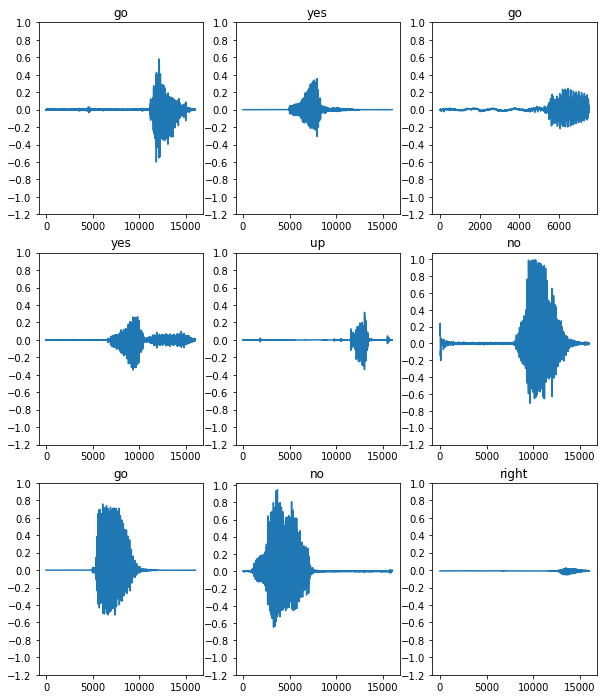

In [10]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# **Step 5:- Spectrogram**

***## We converted the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.***

 ***## A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.***

***## STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`.***


***## We can Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, we can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing.***

***## We also want the waveforms to have the same length, so that when we convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.***

In [11]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=480, frame_step=320, fft_length=512)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

***## Next, we will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.***

In [12]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (49, 257)
Audio playback


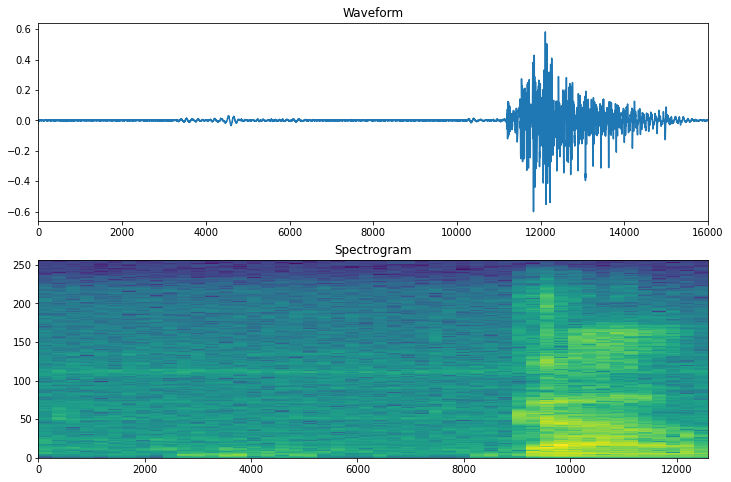

In [13]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

***## Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.***

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


***## Examine the spectrogram "images" for different samples of the dataset.***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


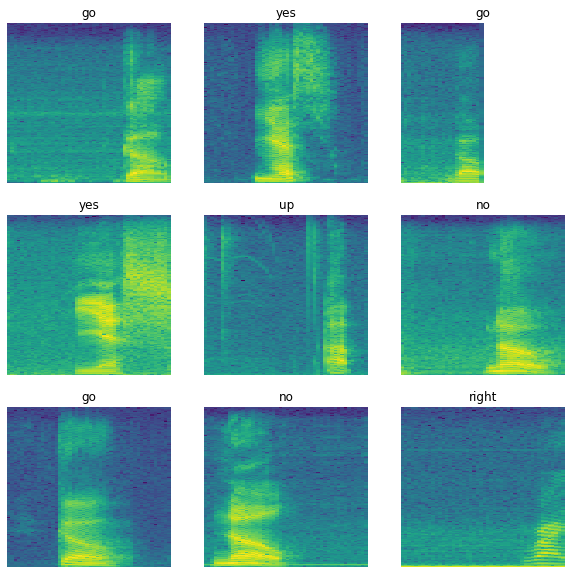

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

# **Step:-6 Build and train the model**

***## Now we can build and train our model. But before we do that, we'll need to repeat the training set preprocessing on the validation and test sets.***

In [17]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print(val_ds)
print(test_ds)


<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


***## Batch the training and validation sets for model training.***

In [19]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

***## Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.***

In [20]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

***## For the model, we'll use a simple LSTM network, since we have transformed the audio files into spectrogram images.***

***## The model also has the following additional preprocessing layers:***
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation. 

***## For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).***

In [54]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print('num_labels:', num_labels)
model = models.Sequential([
    layers.Input(shape=(49, 257), name='input'),
    layers.Reshape(target_shape=(49, 257)),
    layers.LSTM(64, time_major=False, return_sequences=True),
    layers.LSTM(64, time_major=False, return_sequences=True,dropout=0.2, recurrent_dropout=0.2),
    layers.Flatten(),
    layers.Dense(8, activation=tf.nn.softmax, name='output')
])
model.summary()



Input shape: (49, 257, 1)
num_labels: 8
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 49, 257)           0         
                                                                 
 lstm_4 (LSTM)               (None, 49, 64)            82432     
                                                                 
 lstm_5 (LSTM)               (None, 49, 64)            33024     
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 output (Dense)              (None, 8)                 25096     
                                                                 
Total params: 140,552
Trainable params: 140,552
Non-trainable params: 0
_________________________________________________________________


***## Loss function and Optimizer used***

In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

***## Model fit***

In [56]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
   # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
100/100 [==============================] - 29s 237ms/step - loss: 1.2780 - accuracy: 0.5475 - val_loss: 0.8876 - val_accuracy: 0.7250
Epoch 2/100
100/100 [==============================] - 25s 256ms/step - loss: 0.7440 - accuracy: 0.7439 - val_loss: 0.6472 - val_accuracy: 0.7912
Epoch 3/100
100/100 [==============================] - 26s 258ms/step - loss: 0.5253 - accuracy: 0.8203 - val_loss: 0.5758 - val_accuracy: 0.8188
Epoch 4/100
100/100 [==============================] - 21s 205ms/step - loss: 0.4091 - accuracy: 0.8578 - val_loss: 0.5282 - val_accuracy: 0.8288
Epoch 5/100
100/100 [==============================] - 23s 234ms/step - loss: 0.3311 - accuracy: 0.8873 - val_loss: 0.5278 - val_accuracy: 0.8375
Epoch 6/100
100/100 [==============================] - 20s 204ms/step - loss: 0.3062 - accuracy: 0.8925 - val_loss: 0.4654 - val_accuracy: 0.8487
Epoch 7/100
100/100 [==============================] - 23s 231ms/step - loss: 0.2634 - accuracy: 0.9087 - val_loss: 0.5863 -

In [57]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

***## Let's check the training and validation loss & accuracy-val_accuracy curves to see how our model has improved during training.***

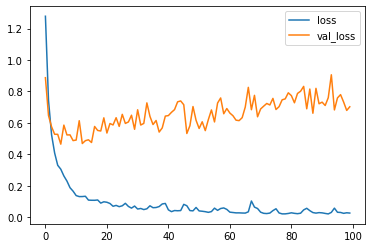

In [58]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# **Step 7:- Evaluate test set performance**

***## Let's run the model on the test set and check performance.***

In [59]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [60]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 5s 64ms/step
Test set accuracy: 91%


# **Step 8:- Display a confusion matrix & Performance metrics**

***## A confusion matrix is helpful to see how well the model did on each of the commands in the test set.***

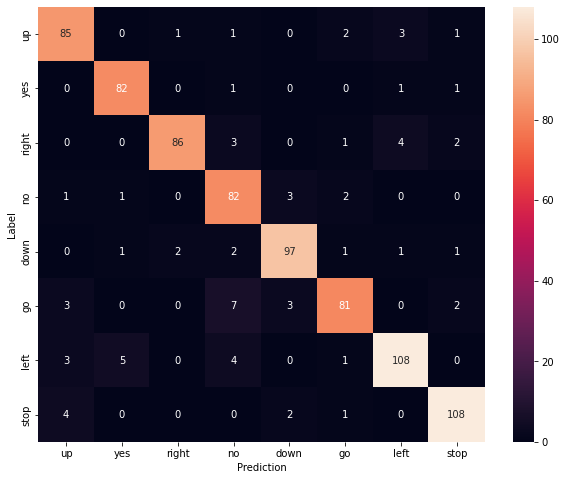

In [61]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

***## Classification report for float32 (Precision, Recall, F1 Score etc)***

In [62]:
from sklearn.metrics import classification_report
target_names = ['go','right','up', 'down', 'stop', 'left', 'no', 'yes']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          go       0.89      0.91      0.90        93
       right       0.92      0.96      0.94        85
          up       0.97      0.90      0.93        96
        down       0.82      0.92      0.87        89
        stop       0.92      0.92      0.92       105
        left       0.91      0.84      0.88        96
          no       0.92      0.89      0.91       121
         yes       0.94      0.94      0.94       115

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



# **Step 9:- Run inference on an audio file**

***## Finally, verify the model's prediction output using an input audio file of someone saying "yes." How well does your model perform?***

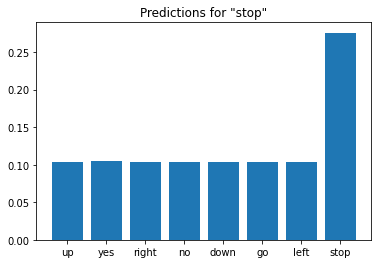

In [63]:
sample_file = '/content/data/mini_speech_commands/stop/4fe01997_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

***--We can see that your model very clearly recognized the audio command as "no."***

In [64]:
model.save("./saved_model.h5/")

# **Step 10:- Run TF (Tensorflow) inference on multiple audio files**

/content/data/mini_speech_commands/yes/8d9cc260_nohash_4.wav


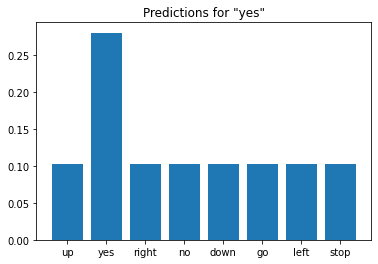

/content/data/mini_speech_commands/yes/1b63157b_nohash_5.wav


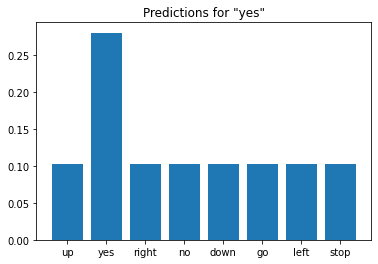

/content/data/mini_speech_commands/yes/611d2b50_nohash_3.wav


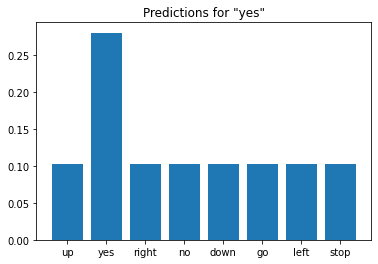

/content/data/mini_speech_commands/yes/72d75d96_nohash_0.wav


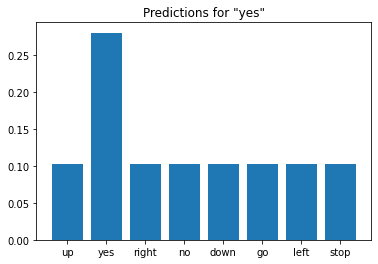

/content/data/mini_speech_commands/yes/735845ab_nohash_1.wav


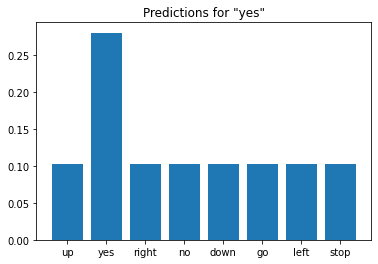

/content/data/mini_speech_commands/yes/c1d39ce8_nohash_2.wav


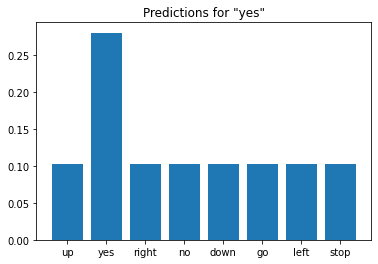

/content/data/mini_speech_commands/yes/1eddce1d_nohash_0.wav


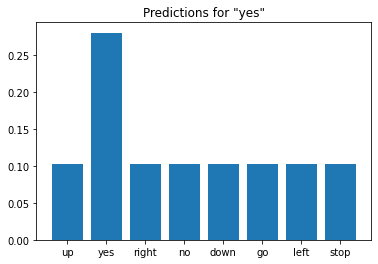

/content/data/mini_speech_commands/yes/afabfa0e_nohash_0.wav


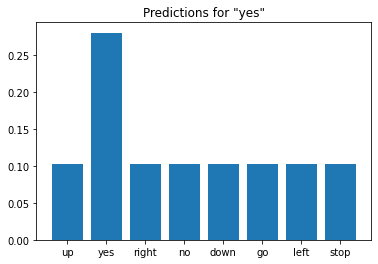

/content/data/mini_speech_commands/yes/311fde72_nohash_0.wav


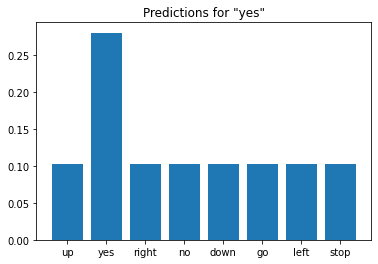

/content/data/mini_speech_commands/yes/cae62f38_nohash_1.wav


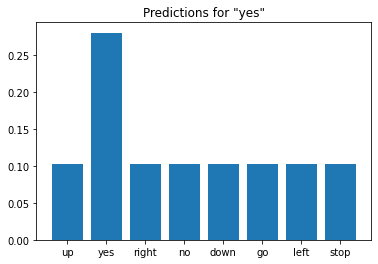

/content/data/mini_speech_commands/yes/cb2929ce_nohash_3.wav


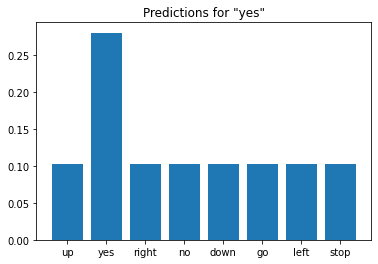

/content/data/mini_speech_commands/yes/4e8c5516_nohash_0.wav


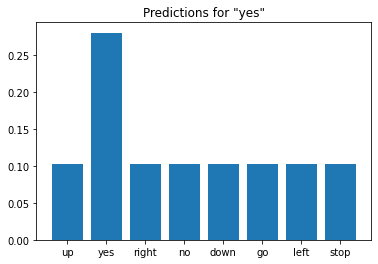

/content/data/mini_speech_commands/yes/dca2797e_nohash_0.wav


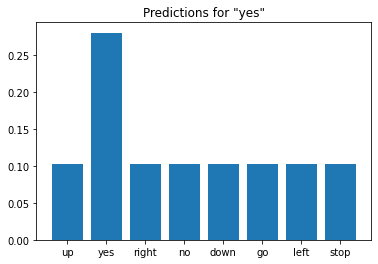

/content/data/mini_speech_commands/yes/439c84f4_nohash_0.wav


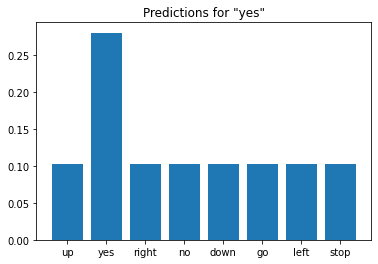

/content/data/mini_speech_commands/yes/eb3f7d82_nohash_2.wav


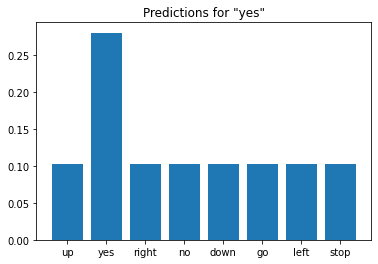

/content/data/mini_speech_commands/yes/9ff2d2f4_nohash_0.wav


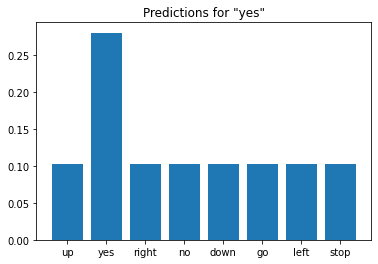

/content/data/mini_speech_commands/yes/03c96658_nohash_0.wav


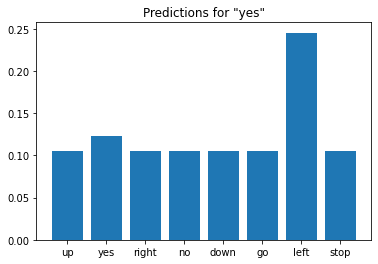

/content/data/mini_speech_commands/yes/763188c4_nohash_4.wav


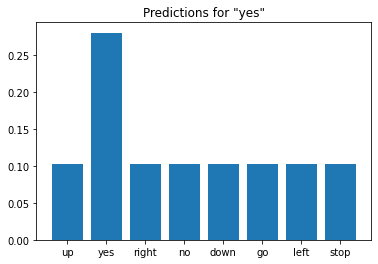

/content/data/mini_speech_commands/yes/56eb74ae_nohash_3.wav


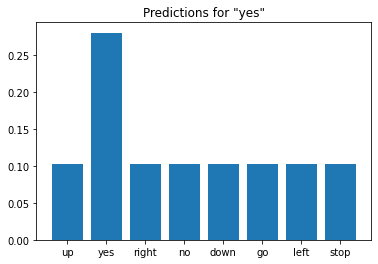

/content/data/mini_speech_commands/yes/9b6c08ba_nohash_2.wav


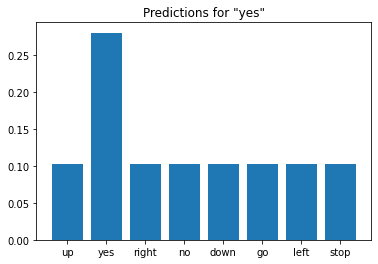

/content/data/mini_speech_commands/yes/826268f8_nohash_0.wav


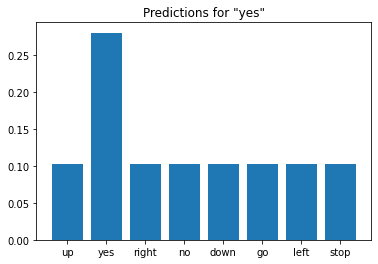

/content/data/mini_speech_commands/yes/234ab0fb_nohash_0.wav


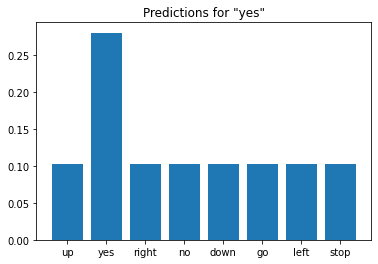

/content/data/mini_speech_commands/yes/695c2127_nohash_0.wav


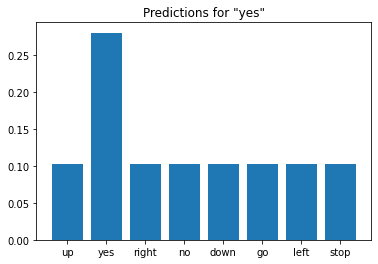

/content/data/mini_speech_commands/yes/106a6183_nohash_1.wav


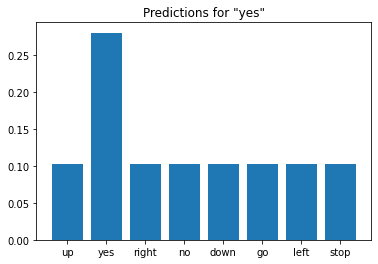

/content/data/mini_speech_commands/yes/56f78b7e_nohash_0.wav


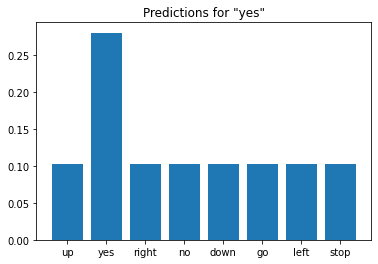

In [65]:
import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/yes/*.wav"):
    txtfiles.append(file)

for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

# ***Step 11:- Convert TF to TF Lite float32 model***

In [66]:
import tensorflow
print(tensorflow.__version__)

run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 49
INPUT_SIZE = 257

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

#Float LSTM model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_float_model = converter.convert()
open('/content/keras_lstm/model_float.tflite', "wb").write(tflite_float_model)



2.12.0-dev20221102


588284

# ***Step 12:- Validate audio files using TFLite float32 model***


In [67]:
# Load quantized TFLite model
tflite_interpreter_float = tf.lite.Interpreter(model_path='/content/keras_lstm/model_float.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_float.get_input_details()
output_details = tflite_interpreter_float.get_output_details()
tflite_interpreter_float.allocate_tensors()

import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/no/*.wav"):
    txtfiles.append(file)

for i in range(25):
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  print(txtfiles[i])
  # Run inference
  for spectrogram, label in sample_ds.batch(1):
    tflite_interpreter_float.set_tensor(input_details[0]['index'],np.array(spectrogram, dtype=np.float32).reshape(1,49, 257) )
    tflite_interpreter_float.invoke()
    tflite_float_model_predictions = tflite_interpreter_float.get_tensor(output_details[0]['index'])
    # Convert prediction results to Pandas dataframe, for better visualization
    # Increase precision of presented data for better side-by-side comparison
    tflite_pred_dataframe = pd.DataFrame(tflite_float_model_predictions)
    tflite_pred_dataframe.columns = commands
    pd.set_option("precision",1)
    print(tflite_pred_dataframe)


/content/data/mini_speech_commands/no/39a12648_nohash_2.wav
        up      yes    right   no     down       go     left     stop
0  8.5e-20  4.5e-19  1.5e-18  1.0  1.0e-10  2.9e-12  2.2e-17  4.8e-22
/content/data/mini_speech_commands/no/b8872c20_nohash_0.wav
        up      yes    right   no     down       go     left     stop
0  9.7e-10  7.0e-11  1.7e-09  1.0  2.9e-07  1.2e-02  1.1e-08  1.5e-14
/content/data/mini_speech_commands/no/611d2b50_nohash_3.wav
    up      yes    right   no     down   go     left     stop
0  0.2  1.1e-02  2.8e-03  0.6  3.5e-03  0.2  5.4e-04  3.0e-06
/content/data/mini_speech_commands/no/4b39347d_nohash_0.wav
        up      yes    right   no     down       go     left     stop
0  8.6e-11  8.2e-16  8.4e-13  1.0  4.4e-09  5.2e-06  2.7e-11  1.1e-16
/content/data/mini_speech_commands/no/c33682f0_nohash_0.wav
        up      yes    right   no     down       go     left     stop
0  1.1e-10  1.7e-13  6.2e-13  1.0  1.6e-05  2.0e-11  1.3e-15  2.4e-12
/content/data/mi

# ***Step 13:- Convert float32 to Quantized int8 model***


In [68]:
import copy

def representative_dataset_3():
  for spectrogram, _ in spectrogram_ds.take(800):
   # print('test')
    flattened_data = np.array(spectrogram, dtype=np.float32).reshape(1,49, 257)
    yield [flattened_data]


converter.representative_dataset = representative_dataset_3
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantized_tflite_model = converter.convert()
open('/content/keras_lstm/model_quantized_minispeech.tflite', "wb").write(quantized_tflite_model)
quant_tflite_model = copy.deepcopy(model)


# ***Step 14: Validate Quantized int8 model***

In [69]:
#test
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path='/content/keras_lstm/model_quantized_minispeech.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()

output_details = tflite_interpreter_quant.get_output_details()

tflite_interpreter_quant.allocate_tensors()


import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/yes/*.wav"):
    txtfiles.append(file)

# sample_file = '/content/data/mini_speech_commands/down/00f0204f_nohash_0.wav'
# print(sample_file)
for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  # Run inference
  for spectrogram, label in sample_ds.batch(1):
    tflite_interpreter_quant.set_tensor(input_details[0]['index'],np.array(spectrogram, dtype=np.int8).reshape(1,49, 257) )
    tflite_interpreter_quant.invoke()
    tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
    tflite_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
    tflite_pred_dataframe.columns = commands
    print(tflite_pred_dataframe)

# print("TFLite prediction results for the first elements")
# tflite_pred_dataframe.head()

/content/data/mini_speech_commands/yes/8d9cc260_nohash_4.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/1b63157b_nohash_5.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/611d2b50_nohash_3.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/72d75d96_nohash_0.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/735845ab_nohash_1.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/c1d39ce8_nohash_2.wav
    up  yes  right   no  down   go  left  stop
0 -128 -128   -128 -128  -128 -128   127  -128
/content/data/mini_speech_commands/yes/1eddce1d_nohash_0.wav
    up  y

# ***Step 15:- Evaluate int8 model using floor and inputscale and zeropoint***

In [85]:
#test
# Load quantized TFLite model
tflite_interpreter_quant_int8 = tf.lite.Interpreter(model_path='/content/keras_lstm/model_quantized_minispeech.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_quant_int8.get_input_details()

output_details = tflite_interpreter_quant_int8.get_output_details()

tflite_interpreter_quant_int8.allocate_tensors()

import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/no/*.wav"):
    txtfiles.append(file)


for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  # Run inference on spectrogram
  for spectrogram, label in sample_ds.batch(1):
    input_scale, input_zero_point = input_details[0]["quantization"]
    print(input_scale)
    print(input_zero_point)
    spectrogram = np.array(spectrogram)
    spectrogram = np.clip(np.floor(spectrogram / input_scale + input_zero_point), -128, 127) # for int8 validation
    q_spectrogram = np.array(spectrogram, dtype=np.int8).reshape(1,49, 257)
    tflite_interpreter_quant_int8.set_tensor(input_details[0]['index'], q_spectrogram )
    tflite_interpreter_quant_int8.invoke()
    tflite_q_model_predictions = tflite_interpreter_quant_int8.get_tensor(output_details[0]['index'])
    print(tflite_q_model_predictions)
    output_scale, output_zero_point = output_details[0]["quantization"]
    tflite_model_predictions = (np.array(tflite_q_model_predictions, dtype=np.float32) - output_zero_point) * output_scale
    tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
    tflite_pred_dataframe.columns = commands
    print(tflite_pred_dataframe)
    # Run inference on test audio 
    q_pred = np.array(test_audio)
    y_qpred = tf.cast(q_pred, tf.int32)
    y_true = test_labels


/content/data/mini_speech_commands/no/39a12648_nohash_2.wav
0.4777274429798126
-128
[[-128 -128 -128  127 -128 -128 -128 -128]]
    up  yes  right   no  down   go  left  stop
0  0.0  0.0    0.0  1.0   0.0  0.0   0.0   0.0
/content/data/mini_speech_commands/no/b8872c20_nohash_0.wav
0.4777274429798126
-128
[[-128 -128 -128  127 -128 -127 -128 -128]]
    up  yes  right   no  down        go  left  stop
0  0.0  0.0    0.0  1.0   0.0  3.91e-03   0.0   0.0
/content/data/mini_speech_commands/no/611d2b50_nohash_3.wav
0.4777274429798126
-128
[[-128 -128 -128 -128 -128 -128  127 -128]]
    up  yes  right   no  down   go  left  stop
0  0.0  0.0    0.0  0.0   0.0  0.0   1.0   0.0
/content/data/mini_speech_commands/no/4b39347d_nohash_0.wav
0.4777274429798126
-128
[[-128 -128 -128  127 -128 -128 -128 -128]]
    up  yes  right   no  down   go  left  stop
0  0.0  0.0    0.0  1.0   0.0  0.0   0.0   0.0
/content/data/mini_speech_commands/no/c33682f0_nohash_0.wav
0.4777274429798126
-128
[[-128 -128 -128  

# **Step 16:- Display a confusion matrix & Performance metrics for Int8**

***## A confusion matrix is helpful to see how well the model did on each of the commands in the test set.***

In [86]:
Y_qpred = np.argmax(quant_tflite_model.predict(y_qpred), axis=1)
y_true = test_labels

quantized_test_acc = sum(Y_qpred == y_true) / len(y_true)
print(f'Quantized Test set accuracy: {quantized_test_acc:.0%}')

25/25 [==============================] - 0s 18ms/step
Quantized Test set accuracy: 70%


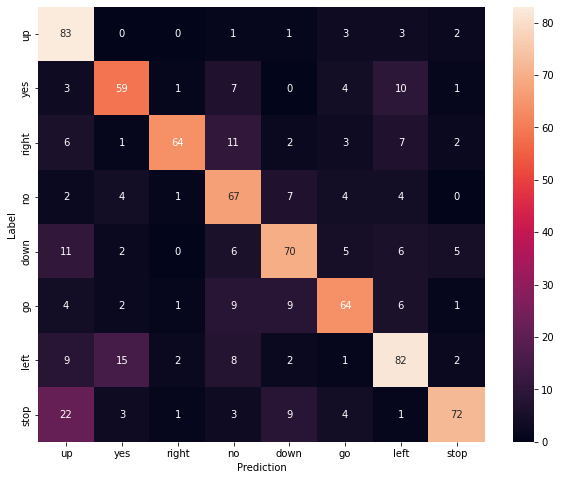

In [87]:
quantized_confusion_mtx = tf.math.confusion_matrix(y_true, Y_qpred) 
plt.figure(figsize=(10, 8))
sns.heatmap(quantized_confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

***## Classification report for int8 (Precision, Recall, F1 Score etc)***

In [82]:
from sklearn.metrics import classification_report
target_names = ['go','right','up', 'down', 'stop', 'left', 'no', 'yes']
print(classification_report(y_true, Y_qpred, target_names=target_names))

              precision    recall  f1-score   support

          go       0.59      0.89      0.71        93
       right       0.69      0.69      0.69        85
          up       0.91      0.67      0.77        96
        down       0.60      0.75      0.67        89
        stop       0.70      0.67      0.68       105
        left       0.73      0.67      0.70        96
          no       0.69      0.68      0.68       121
         yes       0.85      0.63      0.72       115

    accuracy                           0.70       800
   macro avg       0.72      0.71      0.70       800
weighted avg       0.72      0.70      0.70       800

